## Business Problem
Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

## Data
The data used was obtained from the links below: 

* [Box Office Mojo](https://www.boxofficemojo.com/)
* [IMDB](https://www.imdb.com/)
* [Rotten Tomatoes](https://www.rottentomatoes.com/)
* [TheMovieDB](https://www.themoviedb.org/)
* [The Numbers](https://www.the-numbers.com/)


### Goal
The goal is to investigate movie performance to identify patterns, genres, or attributes of successful films.

### Objectives:
1.	Analyze the Movie Data:

    * Identify characteristics of high-performing movies, in terms of genre, budget, runtime, release date, or lead actors/directors.

    * Look for trends in movie popularity and revenue growth over recent years.

2.	Understand Market Demand:

    * Examine the types of movies audiences prefer i.e. genre

    * Identify seasonal trends like during holiday releases, summer etc. to determine the best time for movie releases.

3.	Identify Key Success Factors:

    * Explore factors like movie rating, production budget, etc.

    * Evaluate the impact of sequels or franchise films on box office revenue.

4.	Translate Findings into Recommendations:

    * Provide specific, actionable insights for the company to make data-informed decisions on the types of movies to create.
    
    * Recommend strategies around genre, budget, target demographics, and release timing


In [21]:
# Import the necessary files
import numpy as np
import pandas as pd
import sqlite3
import zipfile
import os

# Import Libraries for plotting    # Visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

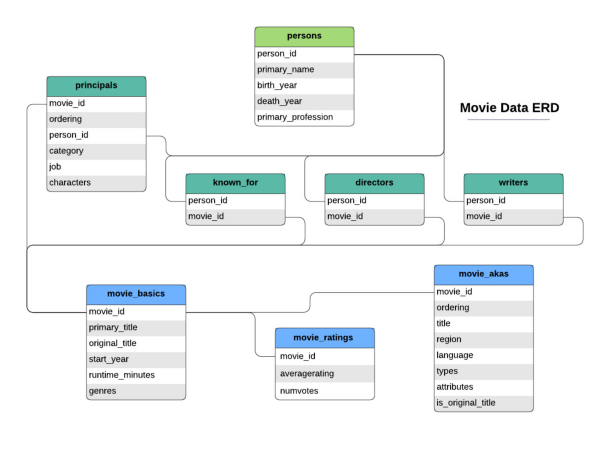

In [22]:
img = mpimg.imread('../Data/movie_data_erd.jpeg')
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

Load Relevant Data

In [23]:
# Extract the zipped files
# zip_path = 'im.db.zip' #the zipped database file path
extracted_db_path = 'im.db'  # create a path where extracted database will be saved
# extracted_db_path

# # Extract the .db file from the zip archive
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(os.path.dirname(extracted_db_path))  # Extracts in the same directory as zip file

# Connect to the extracted SQLite database
conn = sqlite3.connect(extracted_db_path)
cursor = conn.cursor()

In [24]:
#Get the Movie Basics data
movie_basics = pd.read_csv("../Data/movie_basics.csv", index_col=0)
#Read the movie info data using pandas
movie_info = pd.read_csv("../Data/rt.movie_info.tsv.gz", compression='gzip', 
                         header=0, sep='\t', quotechar='"')
#Read the tmdb movie data using pandas
tmdb_movie = pd.read_csv("../Data/tmdb.movies.csv.gz", compression='gzip', 
                         header=0, sep=',', quotechar='"', index_col=0)
#Read the tn_movie budgets data using pandas
tn_movie_budgets = pd.read_csv("../Data/tn.movie_budgets.csv.gz", compression='gzip', 
                      header=0, sep=',', quotechar='"')
#Read the rt_reviews data using pandas
rt_reviews = pd.read_csv("../Data/rt.reviews.tsv.gz", compression='gzip', 
                         header=0, sep='\t', quotechar='"', encoding='windows-1252')
#Read the movie_gross file
bom_movie_gross = pd.read_csv("../Data/bom.movie_gross.csv.gz", compression='gzip', 
                         header=0, sep='\t', quotechar='"', encoding='windows-1252')


Inspect the Data

In [25]:
# Get the list of tables in the database
# pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
movie_basics.columns
movie_info.columns
tmdb_movie.columns
tn_movie_budgets.columns


Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [26]:
# pd.read_sql("SELECT * FROM movie_basics",conn).columns
# pd.read_sql("SELECT * FROM movie_ratings",conn).columns
# pd.read_sql("SELECT * FROM directors",conn).columns

In [27]:
# movie_basics = pd.DataFrame(pd.read_sql("SELECT * FROM movie_basics",conn))
# movie_basics.head()
# movie_basics.to_csv("movie_basics.csv")
# movie_basics.info() #146144 entries, 7 columns
movie_info.info() #1560 entries, 12 columns
# tmdb_movie.info() # 26517 entries, 9 columns
# tn_movie_budgets.info() #5782 entries, 6 columns
# rt_reviews.info() # 54432 entries, 8 columns
# bom_movie_gross.info() #3387 entries, 1 column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


Check for Null values

In [28]:
#Show null values
# movie_basics.isnull().sum() #original_title:21, runtime_minutes:31739, genres:5408 missing records

movie_info.isnull().sum() # Has null values
# tmdb_movie.isnull().sum() # No null values 
# tn_movie_budgets.isnull().sum() # No null values
# rt_reviews.isnull().sum() # Has null values
# bom_movie_gross.isnull().sum() # No Null values

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

Let us check the % of the missing values on movie_basics and movie_info data

In [29]:
# Get missing values count and percentage

movie_basics_missing_values = movie_basics.isnull().sum()

missing_percentage = (movie_basics.isnull().sum() / len(movie_basics)) * 100
missing_percentage

# Create a summary dataframe
missing_summary_df = pd.DataFrame({
    'Missing Values': movie_basics_missing_values,
    'Percentage Missing': missing_percentage})

# Sort by percentage missing
movie_basics_missing_summary = missing_summary_df.sort_values('Percentage Missing', ascending=False);

movie_basics_missing_summary

,Missing Values,Percentage Missing
runtime_minutes,31739,21.717621
genres,5408,3.700460
original_title,21,0.014369
movie_id,0,0.000000
primary_title,0,0.000000
start_year,0,0.000000


In [30]:
# Get missing values count and percentage

movie_info_missing_values = movie_info.isnull().sum()

missing_percentage = (movie_info.isnull().sum() / len(movie_info)) * 100
missing_percentage

# Create a summary dataframe
missing_summary_df = pd.DataFrame({
    'Missing Values': movie_info_missing_values,
    'Percentage Missing': missing_percentage})

# Sort by percentage missing
movie_info_missing_summary = missing_summary_df.sort_values('Percentage Missing', ascending=False);

movie_info_missing_summary

,Missing Values,Percentage Missing
currency,1220,78.205128
box_office,1220,78.205128
studio,1066,68.333333
writer,449,28.782051
theater_date,359,23.012821
dvd_date,359,23.012821
director,199,12.756410
synopsis,62,3.974359
runtime,30,1.923077
genre,8,0.512821


In [31]:
# Drop columns with more than 50% missing values

cols_to_drop = movie_info_missing_summary[movie_info_missing_summary['Percentage Missing'] > 50].index

# Drop these columns
movie_info_cleaned = movie_info.drop(columns=cols_to_drop)
movie_info_cleaned.info()
# movie_info_cleaned.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   runtime       1530 non-null   object
dtypes: int64(1), object(8)
memory usage: 109.8+ KB


In [32]:
#Fill categorical columns with mode
categorical_cols = movie_info_cleaned.select_dtypes(include=['object']).columns

for col in categorical_cols:
    movie_info_cleaned[col].fillna(movie_info_cleaned[col].mode()[0], inplace=True)

# Check if there are any remaining missing values
remaining_missing = movie_info_cleaned.isnull().sum().sum()

print("\
Remaining Missing Values:", remaining_missing)

Remaining Missing Values: 0


In [33]:
movie_info_cleaned.isnull().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
runtime         0
dtype: int64

In [34]:

# split the genre column into a list of genres
movie_info_cleaned['genre_list'] = movie_info_cleaned['genre'].str.split('|')

# Explode to create a new row for each genre
movie_info_cleaned_exploded = movie_info_cleaned.explode('genre_list')

# Display the first few rows
movie_info_cleaned_exploded.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,runtime,genre_list
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Science Fiction and Fantasy


Note: Rated PG: Parental guidance suggested – Some material may not be suitable for children. Rated PG-13: Parents strongly cautioned – Some material may be inappropriate for children under 13. Rated R: Restricted – Under 17 requires accompanying parent or adult guardian. Rated X: No one under 17 admitted

In [35]:
movie_info_cleaned['rating'].value_counts()

R        524
NR       503
PG       240
PG-13    235
G         57
NC17       1
Name: rating, dtype: int64

In [36]:
# Remove the genre_column
movie_info_cleaned_exploded = movie_info_cleaned_exploded.drop('genre', axis=1)

In [37]:
# Rename the genre_list column to genre
movie_info_updated_df = movie_info_cleaned_exploded.rename(columns={'genre_list': 'genre'})

movie_info_updated_df.head(3)

,id,synopsis,rating,director,writer,theater_date,dvd_date,runtime,genre
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Drama


In [38]:
# Extract numeric values from the 'runtime' column
movie_info_updated_df['runtime'] = movie_info_updated_df['runtime'].str.extract('(\d+)').astype(float)

movie_info_updated_df.head(2)

,id,synopsis,rating,director,writer,theater_date,dvd_date,runtime,genre
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104.0,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104.0,Classics


In [39]:
movie_info_updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3581 entries, 0 to 1559
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3581 non-null   int64  
 1   synopsis      3581 non-null   object 
 2   rating        3581 non-null   object 
 3   director      3581 non-null   object 
 4   writer        3581 non-null   object 
 5   theater_date  3581 non-null   object 
 6   dvd_date      3581 non-null   object 
 7   runtime       3581 non-null   float64
 8   genre         3581 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 279.8+ KB


In [40]:
# Get missing values count and pct

movie_budgets_missing_values = tn_movie_budgets.isnull().sum()

movie_budgets_missing_percentage = (tn_movie_budgets.isnull().sum() / len(tn_movie_budgets)) * 100

# Combine into a summary dataframe
missing_summary_budgets = pd.DataFrame({
    'Missing Values': movie_budgets_missing_values,
    'Percentage Missing': movie_budgets_missing_percentage})

missing_summary_budgets

,Missing Values,Percentage Missing
id,0,0.0
release_date,0,0.0
movie,0,0.0
production_budget,0,0.0
domestic_gross,0,0.0
worldwide_gross,0,0.0


In [41]:
#Checking the first 5 rows
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [42]:
#Remove the dollar sign from the numerical columns
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:

    tn_movie_budgets[col] = tn_movie_budgets[col].replace({'\\$': '', ',': ''}, regex=True).astype(float)

# Display the cleaned data types and head of the dataframe to confirm changes

print(tn_movie_budgets[['production_budget', 'domestic_gross', 'worldwide_gross']].head())

   production_budget  domestic_gross  worldwide_gross
0        425000000.0     760507625.0     2.776345e+09
1        410600000.0     241063875.0     1.045664e+09
2        350000000.0      42762350.0     1.497624e+08
3        330600000.0     459005868.0     1.403014e+09
4        317000000.0     620181382.0     1.316722e+09


In [43]:
# Check data types now
tn_movie_budgets.dtypes

id                     int64
release_date          object
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross      float64
dtype: object

In [44]:
#Convert the release date to DateTime Format
tn_movie_budgets["release_date"] = pd.to_datetime(tn_movie_budgets['release_date'])

tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 271.2+ KB


## EDA
### Univariate Analysis
Production_gross, domestic_gross, worldwide_gross, Budget, Genres, Original Language, etc.

In [46]:
movie_basics.columns
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB


In [48]:
#Create a function for adding lables on a barplot
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], rotation = 90)

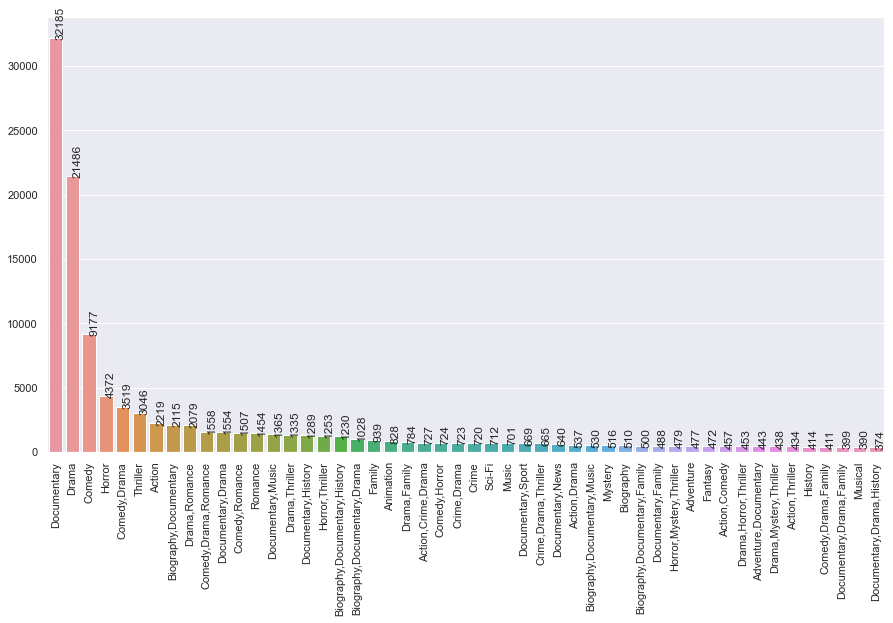

In [ ]:
X= movie_basics['genres'].value_counts()[:50].keys()
X
Y= movie_basics['genres'].value_counts()[:50].values


# Set the graph size
sns.set_theme(rc={'figure.figsize':(15,8)})

#plot a bar graph
genre_bar_plot =sns.barplot(x=X, y=Y);

addlabels(X, Y)
# genre_bar_plot
genre_bar_plot.set_xticklabels(genre_bar_plot.get_xticklabels(), rotation=90);


In [72]:
# sns.set_theme(rc={'figure.figsize':(12,8)})

# sns.countplot(y=movie_basics['genres'][:30]);
# plt.title("Total Number of movies per genre");

In [86]:
tn_movie_budgets.columns
sns.set_theme(rc={'figure.figsize':(12,8)})

prod_budget = tn_movie_budgets['production_budget'].astype(float).sort_values(ascending=False)
prod_budget.tail(10)
# sns.histplot(data=prod_budget[:50]);

5772    9000.0
5777    7000.0
5773    7000.0
5774    7000.0
5775    7000.0
5776    7000.0
5778    6000.0
5779    5000.0
5780    1400.0
5781    1100.0
Name: production_budget, dtype: float64

In [52]:
# tn_movie_budgets.columns
movie_info_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1560 non-null   object
 2   rating        1560 non-null   object
 3   genre         1560 non-null   object
 4   director      1560 non-null   object
 5   writer        1560 non-null   object
 6   theater_date  1560 non-null   object
 7   dvd_date      1560 non-null   object
 8   runtime       1560 non-null   object
 9   genre_list    1560 non-null   object
dtypes: int64(1), object(9)
memory usage: 122.0+ KB


c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


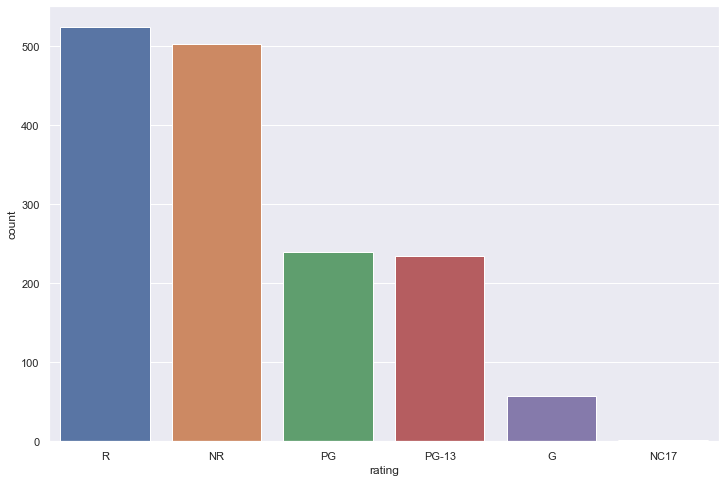

In [81]:
#Check the rating count on the movie_info data
movie_info_cleaned['rating'].value_counts()

sns.countplot(movie_info_cleaned['rating']);


Most of the movies are restricted and non_resticted category

In [135]:
# data1=movie_info['director'].value_counts()[:50] # sort_values(ascending=False)
# data1
# # sns.countplot(data1.values);
# data1_bar = sns.barplot(data1.keys(), data1.values);
# data1_bar.set_xticklabels(data1_bar.get_xticklabels(), rotation=90);

In [55]:
sns.set_theme(rc={'figure.figsize':(12,8)})

### Bivariate Analysis
Budget vs revenue, Genre vs revenue, production cost vs revenue, etc

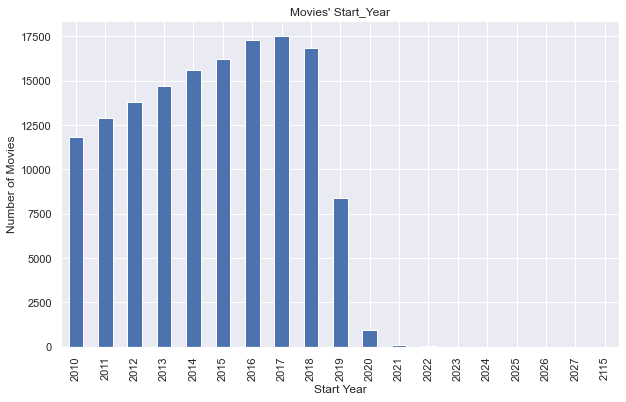

In [112]:
# Group by year and count the number of movie titles per year, then sort by year
yearly_counts = movie_basics.groupby('start_year')['primary_title'].count().sort_index()

# Plotting the counts
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar')
plt.xlabel('Start Year')
plt.ylabel('Number of Movies')
plt.title("Movies' Start_Year")
plt.show()

In [113]:
merged_df = pd.merge(movie_info_updated_df, tn_movie_budgets, on='id', how='inner')
merged_df.columns

Index(['id', 'synopsis', 'rating', 'director', 'writer', 'theater_date',
       'dvd_date', 'runtime', 'genre', 'release_date', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross'],
      dtype='object')

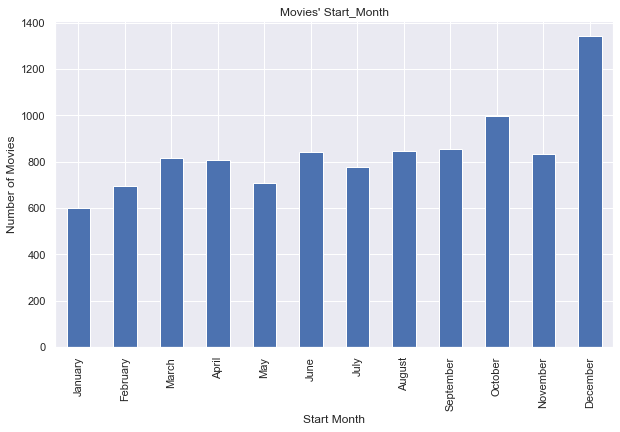

In [ ]:
# Confirm the release_date is datetime
merged_df['release_date'][0]

#Make a copy to wrk with
merged_df_copy = merged_df.copy() #merged_df_copy

# Extract the month from the release_date column and change it to text
merged_df_copy['month'] = merged_df['release_date'].dt.strftime('%B')

# Define the order for months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_type = pd.CategoricalDtype(categories=month_order, ordered=True)

#Create the month column
merged_df_copy['month'] = merged_df_copy['month'].astype(month_type)

# Confirm the month column has been added
merged_df.columns

#Plot by Months
monthly_counts = merged_df_copy.groupby('month')['movie'].count().sort_index()

# Plotting the counts
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='bar')
plt.xlabel('Start Month')
plt.ylabel('Number of Movies')
plt.title("Movies' Start_Month")
plt.show()

Finding: Most of the Movies's release date is in December

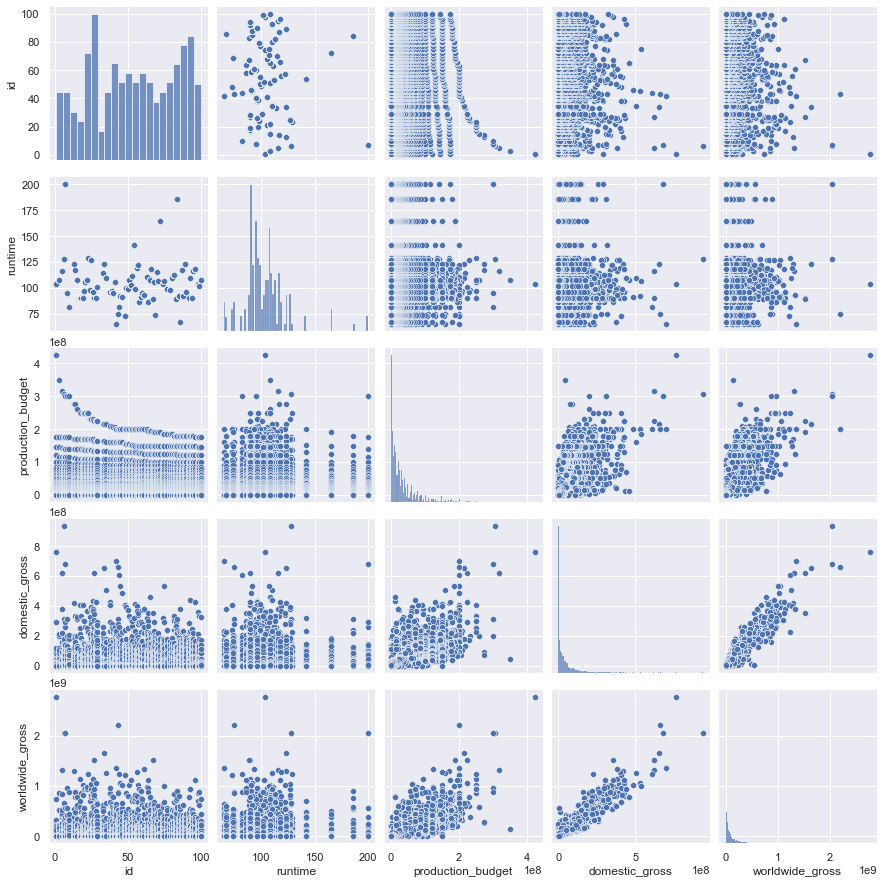

In [ ]:
# Using a pairplot to check the relationships in the merged_df's numerical columns
sns.pairplot(merged_df);

**Note:** There are linear relationships between production budget, domestic gross and the worldwide gross.

Let us check further on statistical analysis.

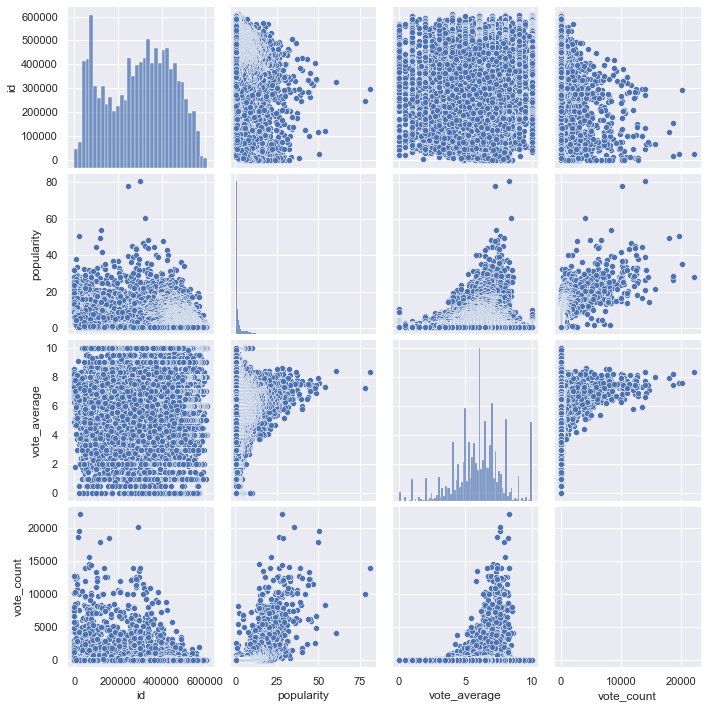

In [ ]:
# Check relations in the tmdb_movie
sns.pairplot(tmdb_movie);

On the tmdb_movie data, there seems to no linear relationships between variables

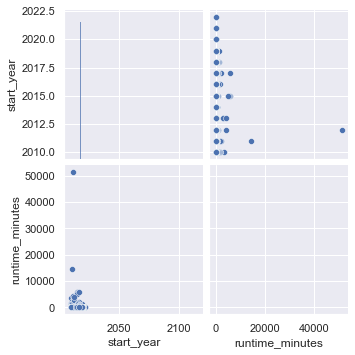

In [77]:
sns.pairplot(movie_basics);

c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201:

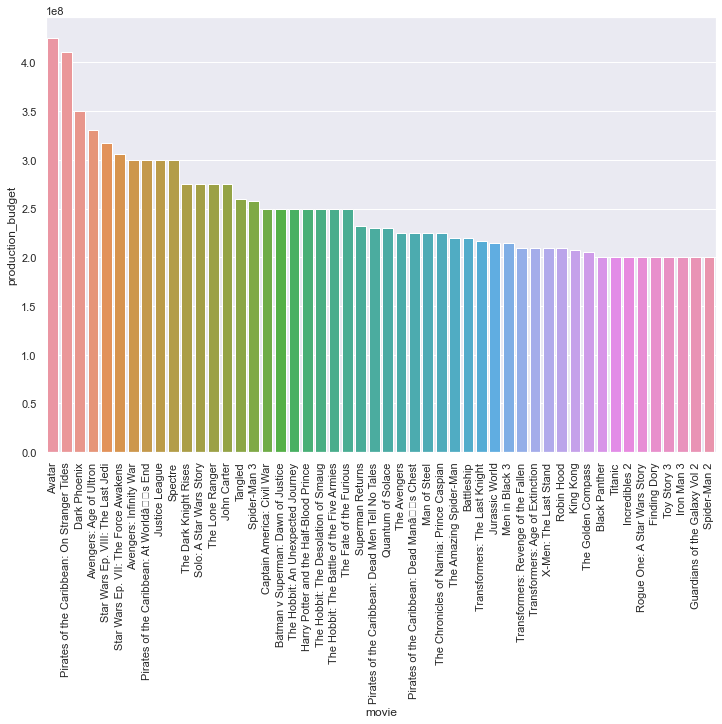

In [56]:
# tn_movie_budgets.columns
# tn_movie_budgets.info()
# tn_movie_budgets.head()
sns.set_theme(rc={'figure.figsize':(12,8)})
budget_movie_bar = sns.barplot(tn_movie_budgets['movie'][:50], tn_movie_budgets['production_budget'][:50]);
budget_movie_bar.set_xticklabels(budget_movie_bar.get_xticklabels(), rotation=90);

c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\amerc\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


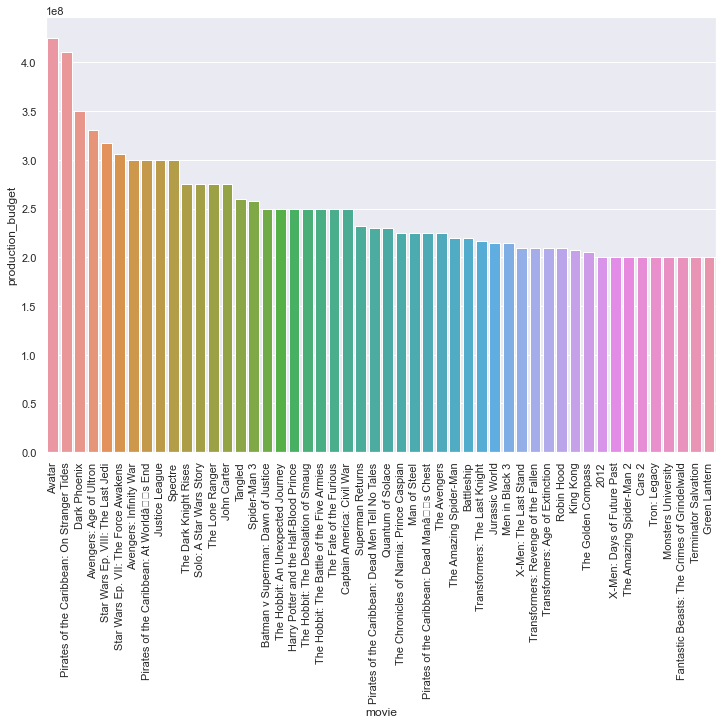

In [57]:
sns.set_theme(rc={'figure.figsize':(12,8)})
data2 = tn_movie_budgets[['production_budget','movie']].sort_values(by='production_budget', ascending=False)[:50]
# A, B = tn_movie_budgets['movie'].sort_values(ascending=False)[:50], tn_movie_budgets['domestic_gross'].sort_values(ascending=False)[:50]
budget_domgross_bar = sns.barplot(x=data2['movie'], y=data2['production_budget']);
budget_domgross_bar.set_xticklabels(budget_domgross_bar.get_xticklabels(), rotation=90);

In [58]:
# tn_movie_budgets['movie'].value_counts()
# tn_movie_budgets['production_budget'].sort_values(ascending=False).head()
tn_movie_budgets[['production_budget','movie']].sort_values(by='production_budget', ascending=False)[:5]

,production_budget,movie
0,425000000.0,Avatar
1,410600000.0,Pirates of the Caribbean: On Stranger Tides
2,350000000.0,Dark Phoenix
3,330600000.0,Avengers: Age of Ultron
4,317000000.0,Star Wars Ep. VIII: The Last Jedi


## Linear Regression/ ML

In [70]:
merged_df.columns

Index(['id', 'synopsis', 'rating', 'director', 'writer', 'theater_date',
       'dvd_date', 'runtime', 'genre', 'release_date', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [71]:
merged_df['rating'].value_counts()

R        4684
NR       2304
PG       1447
PG-13     984
G         692
Name: rating, dtype: int64